In [1]:
import os

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm
from cycler import cycler

from scipy.stats import norm

from astropy.io import fits

from coprofile import COGenerator

from likelihood import ModelLikelihood, FunctionModelLikelihood, SampleInverter

In [2]:
colors = mpl.cm.viridis(np.linspace(0., 1., 5))

axes_style = { 'grid'      : 'True',
               'labelsize' : '14',
               'labelpad'  : '8.0',
               'prop_cycle': cycler('color', colors) }
grid_style = { 'alpha'     : '0.75',
               'linestyle' : ':' }
font_style = { 'size'      : '14' }

mpl.rc('font', **font_style)
mpl.rc('axes', **axes_style)
mpl.rc('grid', **grid_style)

In [3]:
fmu_neg, fmu_fast = 0.066, 0.072
f_ratio = fmu_fast/fmu_neg

In [4]:
mu_neg_file, mu_fast_file = 'models/balco_14co_delta_neg_models.fits', 'models/balco_14co_delta_fast_models.fits'

In [19]:
inverter = SampleInverter()

z = inverter.z
t = inverter.t
z_samp = inverter.z_samp
t_samp = inverter.t_samp

In [26]:
interp = np.zeros((len(z[1:]), len(z_samp)))

for j in range(len(z_samp)+1):
    if j == 0:
        bound = z[1:]<=z_samp[j]
        interp[bound, j] += (z[1:][bound]-z[1])/(z_samp[j]-z[1])
        
        #interp[bound, j+1] += (z_samp[j]-z[1:][bound])/(z_samp[j]-z_samp[j+1])
    elif j == len(z_samp):
        bound = z[1:]>=z_samp[j-1]
        interp[bound, j-1] += (z_samp[j-2]-z[1:][bound])/(z_samp[j-2]-z_samp[j-1])
        
        interp[bound, j-2] += (z_samp[j-1]-z[1:][bound])/(z_samp[j-1]-z_samp[j-2])
    else:
        bound = np.logical_and(z[1:]<=z_samp[j], z[1:]>=z_samp[j-1])
        interp[bound, j-1] += (z_samp[j]-z[1:][bound])/(z_samp[j]-z_samp[j-1])
        
        bound = np.logical_and(z[1:]>=z_samp[j-1], z[1:]<=z_samp[j])
        interp[bound, j] += (z_samp[j-1]-z[1:][bound])/(z_samp[j-1]-z_samp[j])

In [14]:
resolve = np.matmul(inverter.comp, np.matmul(inverter.G_inv, interp))

In [20]:
generator = COGenerator(mu_neg_file, mu_fast_file)

In [21]:
const_profile = generator.generate(rel_uncertainty=0.0)

Text(0.5, 1.0, 'Constant CO Profile Sample')

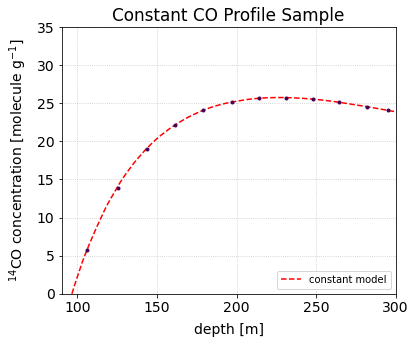

In [22]:
z_samp2, CO_samp, dCO_samp = const_profile.sample_z()

fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.plot(const_profile.z, const_profile.CO, 'r--', label='constant model')
ax.errorbar(z_samp2, CO_samp, yerr=dCO_samp, fmt='.')
ax.set(xlim=(90,300),
        xlabel='depth [m]',
        ylim=(0,35),
        ylabel=r'$^{14}$CO concentration [molecule g$^{-1}$]')
ax.legend(loc='lower right', fontsize=10)
plt.title('Constant CO Profile Sample')

Text(0.5, 1.0, 'CO sample Inverted to f_mu_neg Solution')

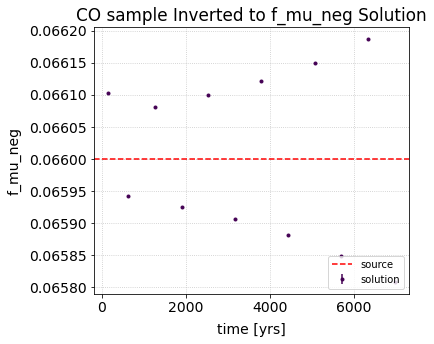

In [23]:
f_solve, df = inverter.solve(CO_samp, dCO_samp)

fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.axhline(0.066, ls='--', c='red', label='source')
ax.errorbar(t_samp, f_solve, yerr=df, fmt='.', label='solution')
ax.set(xlabel='time [yrs]',
        ylabel='f_mu_neg')
ax.legend(loc='lower right', fontsize=10)
plt.title('CO sample Inverted to f_mu_neg Solution')

Text(0.5, 1.0, 'Constant CO Profile Sample w/ Fit')

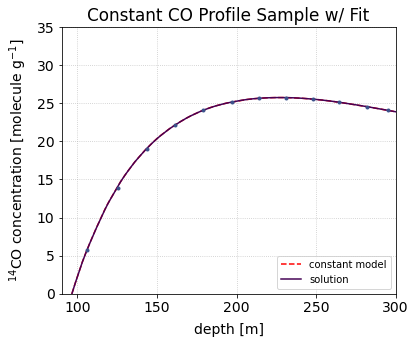

In [24]:
CO_solve = np.matmul(inverter.G, np.matmul(inverter.model, f_solve))


fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.plot(const_profile.z, const_profile.CO, 'r--', label='constant model')
ax.plot(inverter.z[1:], CO_solve, label = 'solution')
ax.errorbar(z_samp2, CO_samp, yerr=dCO_samp, fmt='.')
ax.set(xlim=(90,300),
        xlabel='depth [m]',
        ylim=(0,35),
        ylabel=r'$^{14}$CO concentration [molecule g$^{-1}$]')
ax.legend(loc='lower right', fontsize=10)
plt.title('Constant CO Profile Sample w/ Fit')

In [25]:
const_params = 0.066+np.zeros(12)

B = inverter.likelihood(f_solve, CO_samp, dCO_samp) / inverter.likelihood(const_params, CO_samp, dCO_samp)

print('B_01 = {}'.format(B))

B_01 = nan


C:\Users\walte\Documents\Python Scripts\Dome-C\likelihood.py:494: RuntimeWarning: divide by zero encountered in true_divide
  loglike = -0.5*np.sum(((CO_func - CO_samp) / dCO_samp)**2) - 0.5*N*np.log(2*np.pi) - np.sum(np.log(dCO_samp))
C:\Users\walte\Documents\Python Scripts\Dome-C\likelihood.py:494: RuntimeWarning: invalid value encountered in true_divide
  loglike = -0.5*np.sum(((CO_func - CO_samp) / dCO_samp)**2) - 0.5*N*np.log(2*np.pi) - np.sum(np.log(dCO_samp))
C:\Users\walte\Documents\Python Scripts\Dome-C\likelihood.py:494: RuntimeWarning: divide by zero encountered in log
  loglike = -0.5*np.sum(((CO_func - CO_samp) / dCO_samp)**2) - 0.5*N*np.log(2*np.pi) - np.sum(np.log(dCO_samp))
C:\Users\walte\Documents\Python Scripts\Dome-C\likelihood.py:494: RuntimeWarning: invalid value encountered in double_scalars
  loglike = -0.5*np.sum(((CO_func - CO_samp) / dCO_samp)**2) - 0.5*N*np.log(2*np.pi) - np.sum(np.log(dCO_samp))


Text(0.5, 1.0, 'Constant CO Profile Sample w/ Fits')

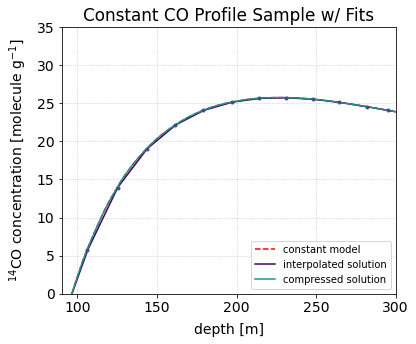

In [27]:
CO_interp = np.matmul(interp, CO_samp)

fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.plot(const_profile.z, const_profile.CO, 'r--', label='constant model')
ax.plot(z[1:], CO_interp, label = 'interpolated solution')
ax.plot(inverter.z[1:], CO_solve, c=colors[2], label = 'compressed solution')
ax.errorbar(z_samp2, CO_samp, yerr=dCO_samp, fmt='.')
ax.set(xlim=(90,300),
        xlabel='depth [m]',
        ylim=(0,35),
        ylabel=r'$^{14}$CO concentration [molecule g$^{-1}$]')
ax.legend(loc='lower right', fontsize=10)
plt.title('Constant CO Profile Sample w/ Fits')

Text(0.5, 1.0, 'CO sample Inverted to f_mu_neg Solution')

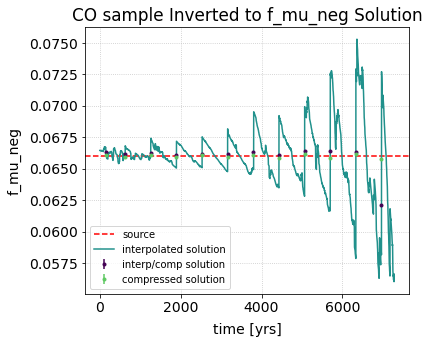

In [34]:
f_supersolve = np.matmul(inverter.G_inv, CO_interp)
f_resolve = np.matmul(inverter.comp, f_supersolve)
df_resolve = np.sqrt(np.sum((resolve * dCO_samp)**2,axis=1))

fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.axhline(0.066, ls='--', c='red', label='source')
ax.plot(t[1:], f_supersolve[1:], c=colors[2], label = 'interpolated solution')
ax.errorbar(t_samp, f_resolve, yerr=df_resolve, fmt='.', label='interp/comp solution')
ax.errorbar(t_samp, f_solve, yerr=df, c=colors[3], fmt='.', label='compressed solution')
ax.set(xlabel='time [yrs]',
        ylabel='f_mu_neg')
ax.legend(loc='lower left', fontsize=10)
plt.title('CO sample Inverted to f_mu_neg Solution')

Text(0.5, 1.0, 'Constant CO Profile Sample w/ Fit')

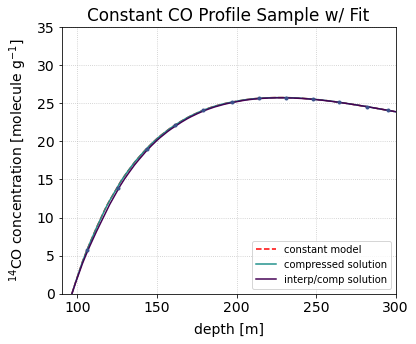

In [32]:
CO_resolve = np.matmul(inverter.G, np.matmul(inverter.model, f_resolve))


fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.plot(const_profile.z, const_profile.CO, 'r--', label='constant model')
ax.plot(inverter.z[1:], CO_solve, c=colors[2], label = 'compressed solution')
ax.plot(inverter.z[1:], CO_resolve, label = 'interp/comp solution')
ax.errorbar(z_samp2, CO_samp, yerr=dCO_samp, fmt='.')
ax.set(xlim=(90,300),
        xlabel='depth [m]',
        ylim=(0,35),
        ylabel=r'$^{14}$CO concentration [molecule g$^{-1}$]')
ax.legend(loc='lower right', fontsize=10)
plt.title('Constant CO Profile Sample w/ Fit')

In [17]:
const_params = 0.066+np.zeros(12)

B = inverter.likelihood(f_resolve, CO_samp, dCO_samp) / inverter.likelihood(const_params, CO_samp, dCO_samp)

print('B_01 = {}'.format(B))

B_01 = 0.6709459357789305
